#  Détection de phonèmes par analyse du signal vocal

L'objectif de ce TP consiste à détecter et reconnaître les phonèmes  à partir de fichiers sonores au format *.wav* via l'analyse cepstrale.



Vous disposez d'une base d'apprentissage et une base de test. Il faut reconnaître tous les phénomènes suivants :
$$'a','e','e\_aigu','e\_grave','i','o','o\_ouvert','ou','u'$$


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math

Les lignes de code suivantes permettent de transformer le fichier audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

Comme chaque fichier a une durée différente, on calcule la moyenne des MFCC sur toutes les fenêtres de discrétisation. 

La matrice de sortie est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 13.

In [2]:
import librosa

In [3]:
from os import listdir
from os.path import isfile, join
fichiers = [f for f in listdir("./Data/")]
sort_fichiers = sorted(fichiers)
DataMFCC=[]
label=[]
#print(sort_fichiers)

# Calcul des MFCC sur tous les fichiers de la base de données
for i in range(len(sort_fichiers)):
    # chargement du fichier audio
    y, sr = librosa.load("./Data/" + sort_fichiers[i])
    mfccBA = librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True, n_mfcc=13)
    # Stockage et calcul du MFCC moyen pour le phonème
    DataMFCC.append(np.mean(mfccBA,axis=1))
    # Stockage de l'étiquette label
    label.append(i//10)

DataMFCC=np.asarray(DataMFCC)
label=np.asarray(label)
print(DataMFCC.shape)

(90, 13)


In [25]:
# Phonème associé à chaque valeur de label
Liste_label=['a','e','e aigu','e grave','i','o','o ouvert','ou','u'] 

In [5]:
# Séparation de l'ensemble de données en Base d'apprentissage et base de test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(DataMFCC, label, random_state=0,test_size=0.2)

print('Dimension Base d apprentissage :', X_train.shape)
print('Dimension Base de test :', X_test.shape)

Dimension Base d apprentissage : (72, 13)
Dimension Base de test : (18, 13)


# Partie I : Classification des phonèmes sans prétraitement 

Réaliser une classification de ces phonèmes par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser le triangle voyellique présenté ci-après pour interpréter les résultats.

## Méthode supervisée  : 
indiquer quelle est la méthode superviée de votre choix et calculer la matrice de confusion associée. 

La classification que nous avons choisie est la classif Bayésienne. 

C:\Users\twilc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


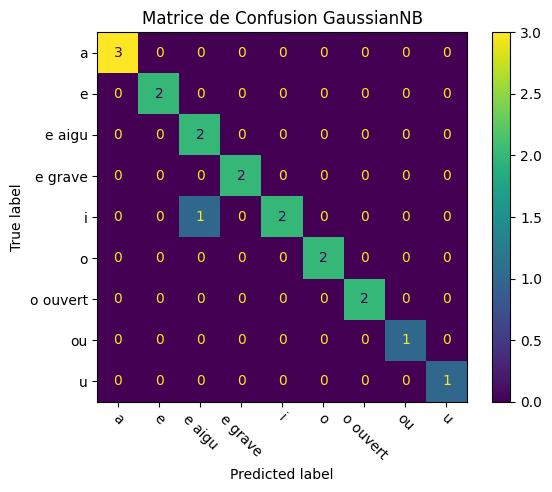

In [26]:
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB

classif_gaussian = GaussianNB().fit(X_train, y_train)

# Calcul et affichage de la matrice de confusion (pas besoin de la calculer, plor_confusion_matrix s'en charge en plus de l'affichage)
disp = metrics.plot_confusion_matrix(classif_gaussian, X_test, y_test,
                                 display_labels=Liste_label,
                                 cmap=None,
                                 normalize=None)
plt.xticks(rotation=-45)
disp.ax_.set_title('Matrice de Confusion GaussianNB');

On a une seule valeur mal classifiée : un i classifié comme é, voyelles très proches sur le triangle voyellique. 

Nous n'avons pas trouvé de paramètres à faire varier dans la fonction GaussianNB de sklearn.

A des fins de test, nous avons également testé avec la méthode K-ppv :

C:\Users\twilc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


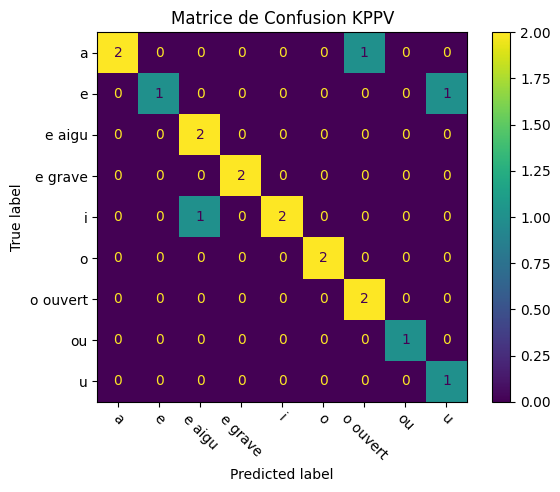

In [106]:
from sklearn.neighbors import KNeighborsClassifier

classif_kppv = KNeighborsClassifier().fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(classif_kppv, X_test, y_test,
                                 display_labels=Liste_label,
                                 cmap=None,
                                 normalize=None)
plt.xticks(rotation=-45)
disp.ax_.set_title('Matrice de Confusion KPPV');

La classification est moins bonne qu'avec la cassif bayesienne. On constate plus d'erreurs, mais elles restent entre des voyelles adjacentes. 

## Méthode non supervisée

Nous avons choisi la méthode KMeans.

C:\Users\twilc\AppData\Local\Temp\ipykernel_7648\2916810480.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + Liste_label)
C:\Users\twilc\AppData\Local\Temp\ipykernel_7648\2916810480.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + Liste_label)


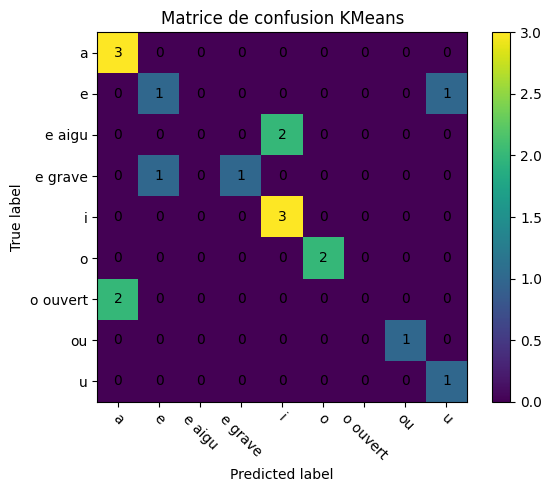

In [171]:
from sklearn.cluster import KMeans

classif_kmeans = KMeans(n_clusters=len(Liste_label), max_iter = 300, random_state=0).fit(X_train)

y_pred = classif_kmeans.predict(X_test)

# Le problème du clustering, c'est que même si l'algo rassemble les points entre eux, il est incapable de dire à quel label les groupes correspondent. 
# On va donc réorganiser les clusters : pour chaque ensemble de point associé au même cluster par la prédiction, je regarde à quel label correspondent ces points selon nos données 
# terrain (y_test), et je corrige le numéro de label donné à chaque cluster par predict(). D'une certaine manière, j'ai donc ajouté une partie supervisée en post-traitement : cependant 
# cela n'influe que sur la visualisation de la matrice de confusion. L'intérêt reste d'observer si les points ayant le même label réel (y_test) sont bien dans le même cluster. 

# Je rassemble les points ayant été attribués au même cluster
indexes = []
for i in range(len(Liste_label)):
    indexes += [[]]

for i in range(len(y_pred)):
    indexes[y_pred[i]] += [i]

reorganized_pred = []
right_classes = [0] * len(Liste_label)

# J'utilise le true label des points d'un cluster pour associer chaque cluster à un label 
for i in range(len(indexes)):
    if len(indexes[i]) > 0:
        right_classes[i] = y_test[indexes[i][0]]

# Je repasse sur y_pred (qui indique le cluster de chaque point) et je remplace le cluster par le label. 
for pred in y_pred:
    reorganized_pred += [right_classes[pred]]

# Calcul de la matrice de confusion
matrix = metrics.confusion_matrix(y_test, reorganized_pred)

# Affichage de la matrice.
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Matrice de confusion KMeans')
fig.colorbar(cax)
ax.set_xticklabels([''] + Liste_label)
ax.set_yticklabels([''] + Liste_label)
ax.xaxis.set_ticks_position('bottom')
for (i, j), z in np.ndenumerate(matrix):
    ax.text(j, i, '{0}'.format(z), ha='center', va='center')
plt.xlabel('Predicted label')
plt.xticks(rotation = -45)
plt.ylabel('True label')
plt.show()

La classification est moins bonne. Après essai avec de nombreux randomstates différents, on observe
- le le ou, le o et le u sont presque toujours bien classifiés
- certains e sont souvents classés avec les u (voyelles adjacentes sur le triangle voyellique)
- le modèle n'arrive presque jamais à faire la différence entre les e aigus et les i (voyelles adjacentes sur le triangle)
- de même avec les o ouverts et les a (voyelles proches)

De manière générale, ce modèle fait beaucoup d'erreurs, mais elles se font en général entre des voyelles proches sur le triangle voyellique. 

Nous avons essayé de faire varier le nombre max d'itérations de l'algorithme, sans vraiment constater de différence notable.

# Partie II : classification des phonèmes avec prétraitement 


## Méthode supervisée


In [188]:
from sklearn.decomposition import PCA

# Fonction de réduction des dimensions
def transformACP(data, threshold):
  acp = PCA().fit(data)
  #Après l'analyse en composantes principales, je ne garde que les composantes suffisantes pour atteindre un certaine variance expliquée. 
  variance_ratios = acp.explained_variance_ratio_
  sum = 0
  i = 0
  for i in range(len(variance_ratios)):
    sum += variance_ratios[i]
    if sum > threshold:
      break

  result = result = acp.transform(data)
  return result[:,:i]

transformedData = transformACP(DataMFCC, 0.70)

X_train, X_test, y_train, y_test = train_test_split(transformedData, label, random_state=0,test_size=0.2)

(72, 1)


C:\Users\twilc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


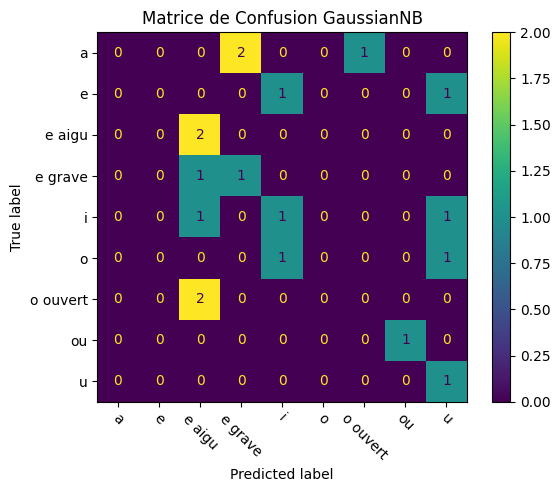

In [183]:
# Calcul de la matrice de confusion
print(X_train.shape)
classif_gaussian = GaussianNB().fit(X_train, y_train)

# Calcul de la matrice de confusion

disp = metrics.plot_confusion_matrix(classif_gaussian, X_test, y_test,
                                 display_labels=Liste_label,
                                 cmap=None,
                                 normalize=None)
plt.xticks(rotation=-45)
disp.ax_.set_title('Matrice de Confusion GaussianNB');

#confusion_matrix(y_true, y_pred)

Avec 95% de l'information, on constate très peu de différence avec le traitrement sans ACP, modulo une erreur entre o et o ouvert (adjacentes sur le triangle).  
Idem avec 80% de l'information.  
Avec 70% de l'information cependant, la classification ne fonctionne quasiment plus. Certains labels n'ont plus aucune données attribuées, et les erreurs se font entre des voyelles assez éloignées sur le triangle voyellique (exemple : o et i)

## Méthode non supervisée

C:\Users\twilc\AppData\Local\Temp\ipykernel_7648\2895978377.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + Liste_label)
C:\Users\twilc\AppData\Local\Temp\ipykernel_7648\2895978377.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + Liste_label)


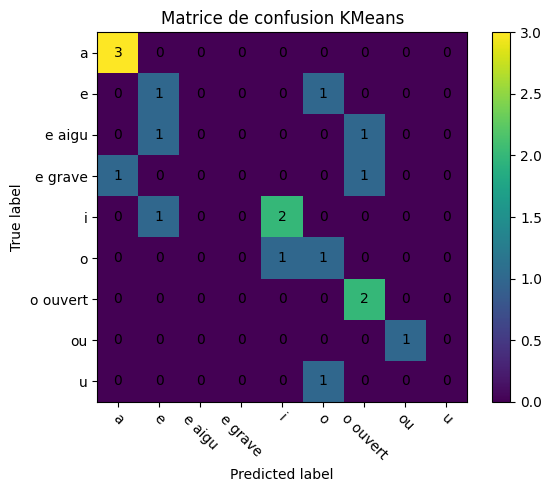

In [191]:
classif_kmeans = KMeans(n_clusters=len(Liste_label)).fit(X_train)

y_pred = classif_kmeans.predict(X_test)

indexes = []
for i in range(len(Liste_label)):
    indexes += [[]]

for i in range(len(y_pred)):
    indexes[y_pred[i]] += [i]

reorganized_pred = []
right_classes = [0] * len(Liste_label)

for i in range(len(indexes)):
    if len(indexes[i]) > 0:
        right_classes[i] = y_test[indexes[i][0]]

for pred in y_pred:
    reorganized_pred += [right_classes[pred]]

matrix = metrics.confusion_matrix(y_test, reorganized_pred)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Matrice de confusion KMeans')
fig.colorbar(cax)
ax.set_xticklabels([''] + Liste_label)
ax.set_yticklabels([''] + Liste_label)
ax.xaxis.set_ticks_position('bottom')
for (i, j), z in np.ndenumerate(matrix):
    ax.text(j, i, '{0}'.format(z), ha='center', va='center')
plt.xlabel('Predicted label')
plt.xticks(rotation = -45)
plt.ylabel('True label')
plt.show()

Avec 95% de l'information, on constate une certaine dégradation par rapport au KMeans sans ACP. 
Cependant, avec 70%, la dégradation reste moins intense que pour la Bayésienne avec le même niveau de réduction de dimensions. 

## Partie III : Analyse des résultats 

Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser le triangle voyellique présenté ci-après pour interpréter les résultats.

<img src="files/triangle_voyellique.jpg" width="600" height="600"  >